In [0]:
#delete uploaded files
!ls -al

total 91700
drwxr-xr-x 1 root root     4096 Oct  3 16:32  .
drwxr-xr-x 1 root root     4096 Oct  3 15:29  ..
drwxr-xr-x 1 root root     4096 Sep 27 15:12  .config
-rw-r--r-- 1 root root 89781419 Oct  3 16:27 'HumanActivityRecognition (1).zip'
-rw-r--r-- 1 root root   716800 Oct  3 16:32 'HumanActivityRecognition (2).zip'
-rw-r--r-- 1 root root  3379200 Oct  3 15:35  HumanActivityRecognition.zip
drwxr-xr-x 1 root root     4096 Aug 27 16:17  sample_data


In [0]:
#https://dev.to/kriyeng/8-tips-for-google-colab-notebooks-to-take-advantage-of-their-free-of-charge-12gb-ram-gpu-be4
!rm -rf HumanActivityRecognition
!ls -al

total 91700
drwxr-xr-x 1 root root     4096 Oct  3 16:32  .
drwxr-xr-x 1 root root     4096 Oct  3 15:29  ..
drwxr-xr-x 1 root root     4096 Sep 27 15:12  .config
-rw-r--r-- 1 root root 89781419 Oct  3 16:27 'HumanActivityRecognition (1).zip'
-rw-r--r-- 1 root root   716800 Oct  3 16:32 'HumanActivityRecognition (2).zip'
-rw-r--r-- 1 root root  3379200 Oct  3 15:35  HumanActivityRecognition.zip
drwxr-xr-x 1 root root     4096 Aug 27 16:17  sample_data


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# Importing Libraries
from google.colab import files
uploaded = files.upload()

In [0]:
from zipfile import ZipFile
zip_file = ZipFile('drive/My Drive/HumanActivityRecognition.zip', 'r')
zip_file.extractall()

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
import os

os.listdir('HAR/UCI_HAR_Dataset/train/Inertial Signals')

['total_acc_y_train.txt',
 'body_acc_z_train.txt',
 'body_gyro_x_train.txt',
 'body_acc_x_train.txt',
 'body_gyro_z_train.txt',
 'total_acc_z_train.txt',
 'body_acc_y_train.txt',
 'total_acc_x_train.txt',
 'body_gyro_y_train.txt']

In [0]:
# Data directory
DATADIR = 'HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = 'HAR/UCI_HAR_Dataset/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
        signals_data.append(_read_csv(filename).as_matrix()) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
import tensorflow as tf
np.random.seed(42)
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()
print(Y_train.shape)
print(X_train.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


(7352, 6)
(7352, 128, 9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(n_classes)

128
9
7352
6


<h4>- Defining the Architecture of LSTM </h4>

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.3174 - acc: 0.4421 - val_loss: 1.1341 - val_acc: 0.4835
Epoch 2/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.9761 - acc: 0.5778 - val_loss: 0.9061 - val_acc: 0.6023
Epoch 3/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.7827 - acc: 0.6459 - val_loss: 0.7952 - val_acc: 0.6098
Epoch 4/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.7027 - acc: 0.6544 - val_loss: 0.8491 - val_acc: 0.5796
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.6593 - acc: 0.6666 - val_loss: 0.7274 - val_acc: 0.6152
Epoch 6/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.6333 - acc: 0.6657 - val_loss: 1.1423 - val_acc: 0.4886
Epoch 7/30
7352/7352 [==========================

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  0      384  ...                   0                 3
STANDING                 0       89  ...                   0                 0
WALKING                  0        0  ...                  29                 6
WALKING_DOWNSTAIRS       0        0  ...                 391                 8
WALKING_UPSTAIRS         0        0  ...                  25               391

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 286us/step


In [0]:
score

[0.6656655673765173, 0.8754665761791652]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

<h3> LSTM with hyper-parameter tuning </h3>

<h3> 1-Layer LSTM Layer with hidden layer = 128 with dropout = 0.5

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 128

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 58s 8ms/step - loss: 1.2456 - acc: 0.4557 - val_loss: 1.3252 - val_acc: 0.5019
Epoch 2/30
7352/7352 [==============================] - 57s 8ms/step - loss: 1.0615 - acc: 0.5525 - val_loss: 0.9132 - val_acc: 0.5687
Epoch 3/30
7352/7352 [==============================] - 57s 8ms/step - loss: 0.8432 - acc: 0.6149 - val_loss: 0.7018 - val_acc: 0.6702
Epoch 4/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.6686 - acc: 0.6984 - val_loss: 0.8546 - val_acc: 0.6502
Epoch 5/30
7352/7352 [==============================] - 57s 8ms/step - loss: 0.5301 - acc: 0.7919 - val_loss: 0.6405 - val_acc: 0.8385
Epoch 6/30
7352/7352 [==============================] - 57s 8ms

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 535        0  ...                   0                 2
SITTING                  0      411  ...                   0                 2
STANDING                 0       64  ...                   0                 0
WALKING                  0        5  ...                   3                32
WALKING_DOWNSTAIRS       0        0  ...                 419                 1
WALKING_UPSTAIRS         0       12  ...                   2               454

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 2s 777us/step


[0.3652639494159514, 0.9253478113335596]

<h3> 1-Layer LSTM Layer with hidden layer = 324 with slight change in dropout = 0.6

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 324
drop_out_rate = 0.6

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 212s 29ms/step - loss: 1.3286 - acc: 0.4166 - val_loss: 1.0828 - val_acc: 0.5501
Epoch 2/30
7352/7352 [==============================] - 229s 31ms/step - loss: 1.1838 - acc: 0.4912 - val_loss: 0.8407 - val_acc: 0.5741
Epoch 3/30
7352/7352 [==============================] - 235s 32ms/step - loss: 0.9446 - acc: 0.5872 - val_loss: 0.6848 - val_acc: 0.6637
Epoch 4/30
7352/7352 [==============================] - 231s 31ms/step - loss: 0.6721 - acc: 0.7187 - val_loss: 0.7442 - val_acc: 0.7377
Epoch 5/30
7352/7352 [==============================] - 213s 29ms/step - loss: 0.4905 - acc: 0.8282 - val_loss: 0.4165 - val_acc: 0.8191
Epoch 6/30
7352/7352 [==============================] - 215s 29ms/step - loss: 0.3099 - acc: 0.9000 - val_loss: 0.2471 - val_acc: 0.9125
Epoch 7/30
7352/7352 [==============================] - 219s 30ms/step - loss: 0.3146 - acc: 0.8784 - val_loss: 0.2701 - val_acc: 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
score

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  0      420  ...                   0                 0
STANDING                 0      136  ...                   0                 0
WALKING                  0        0  ...                   9                 4
WALKING_DOWNSTAIRS       0        0  ...                 412                 6
WALKING_UPSTAIRS         0        0  ...                   0               470

[6 rows x 6 columns]
2947/2947 [==============================] - 10s 3ms/step


[0.24575160282353592, 0.9222938581608415]

<h3> 2-Layer LSTM Layer with hidden layer, h1 = 256 & h2 = 128 with dropout 0.7 & 0.6 respectively

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
hidden_layer_1 = 256
hidden_layer_2 = 128

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(hidden_layer_1, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation

model.add(LSTM(hidden_layer_2, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.6))

model.add(Dense(n_classes, activation='sigmoid'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 244s 33ms/step - loss: 1.1505 - acc: 0.4954 - val_loss: 0.9023 - val_acc: 0.6040
Epoch 2/30
7352/7352 [==============================] - 245s 33ms/step - loss: 0.7672 - acc: 0.6261 - val_loss: 0.7036 - val_acc: 0.6312
Epoch 3/30
7352/7352 [==============================] - 240s 33ms/step - loss: 0.5638 - acc: 0.7518 - val_loss: 0.5465 - val_acc: 0.7625
Epoch 4/30
7352/7352 [==============================] - 242s 33ms/step - loss: 0.4074 - acc: 0.8515 - val_loss: 0.3847 - val_acc: 0.8426
Epoch 5/30
7352/7352 [==============================] - 243s 33ms/step - loss: 0.3439 - acc: 0.8900 - val_loss: 0.4130 - val_acc: 0.8853
Epoch 6/30
7352/7352 [==============================] - 243s 33ms/step - loss: 0.2120 - acc: 0.9255 - val_loss: 0.4807 - val_acc: 0.8775
Epoch 7/30
7352/7352 [==============================] - 242s 33ms/step - loss: 0.2226 - acc: 0.9270 - val_loss: 0.3342 - val_acc: 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
score

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 534        0  ...                   0                 1
SITTING                  0      421  ...                   0                 2
STANDING                 0      102  ...                   0                 0
WALKING                  0        0  ...                  12                18
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         0        0  ...                  37               373

[6 rows x 6 columns]
2947/2947 [==============================] - 11s 4ms/step


[0.6089694898658435, 0.8971835765184933]

<h3> 2-Layer LSTM Layer with hidden layer, h1 = 128 & h2 = 64 with dropout 0.2 & 0.5 respectively.

In [0]:
epochs1 = 30
batch_size1= 32
n_hidden1 = 128
n_hidden2 =64

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.2))
# Adding a dense output layer with sigmoid activation

model.add(LSTM(n_hidden2, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='sigmoid'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 104s 14ms/step - loss: 1.0464 - acc: 0.5518 - val_loss: 0.8646 - val_acc: 0.5806
Epoch 2/30
7352/7352 [==============================] - 100s 14ms/step - loss: 0.7524 - acc: 0.6366 - val_loss: 0.7521 - val_acc: 0.6281
Epoch 3/30
7352/7352 [==============================] - 104s 14ms/step - loss: 0.6602 - acc: 0.6680 - val_loss: 0.7574 - val_acc: 0.6342
Epoch 4/30
7352/7352 [==============================] - 109s 15ms/step - loss: 0.5374 - acc: 0.7575 - val_loss: 0.5413 - val_acc: 0.7557
Epoch 5/30
7352/7352 [==============================] - 112s 15ms/step - loss: 0.5465 - acc: 0.7612 - val_loss: 0.7143 - val_acc: 0.7642
Epoch 6/30
7352/7352 [==============================] - 113s 15ms/step - loss: 0.2840 - acc: 0.9094 - val_loss: 0.4414 - val_acc: 0.8761
Epoch 7/30
7352/7352 [==============================] - 100s 14ms/step - loss: 0.2163 - acc: 0.9276 - val_loss: 0.5205 - val_acc: 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
score

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 536        1  ...                   0                 0
SITTING                  6      401  ...                   0                 0
STANDING                 0       87  ...                   0                 0
WALKING                  0        1  ...                   2                 3
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         1        9  ...                   1               444

[6 rows x 6 columns]
2947/2947 [==============================] - 4s 1ms/step


[0.24457379243686445, 0.9277231082456736]

<h2> CNN </h2>

In [0]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
    
timesteps = 128
input_dim = 9
n_classes = 6

model = Sequential()
# Configuring the parameters
model.add(Conv1D(filters = 561, kernel_size=4, activation='relu',padding = 'same', input_shape = (timesteps,input_dim)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters = 1024, kernel_size=4, activation='relu',padding = 'same'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Conv1D(filters = 559, kernel_size=4, activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(filters = 512, kernel_size=2,
             activation='sigmoid',padding = 'same'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, activation='sigmoid'))

model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.7))

model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='sigmoid'))

# Adding a dense output layer with sigmoid activation
model.add(Dropout(0.10))
model.add(Dense(n_classes, activation='softmax'))

#adam = keras.optimizers.Adam(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})
rmsprop = keras.optimizers.RMSprop(lr=10**-4)
# sgd = keras.optimizers.SGD(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=rmsprop)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 128, 561)          20757     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 64, 561)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 64, 1024)          2298880   
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 21, 1024)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 21, 1024)          4096      
_________________________________________________________________
dropout_7 (Dropout)          (None, 21, 1024)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 21, 559)          

In [0]:
history = model.fit(X_train, Y_train,
          batch_size=16,
          nb_epoch=26,
          verbose=2,
          validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 7352 samples, validate on 2947 samples
Epoch 1/26
 - 791s - loss: 1.2415 - acc: 0.4433 - val_loss: 0.8487 - val_acc: 0.5297
Epoch 2/26
 - 754s - loss: 0.6440 - acc: 0.7474 - val_loss: 0.8403 - val_acc: 0.6522
Epoch 3/26
 - 761s - loss: 0.3747 - acc: 0.8949 - val_loss: 0.4197 - val_acc: 0.8758
Epoch 4/26
 - 756s - loss: 0.2861 - acc: 0.9168 - val_loss: 0.3781 - val_acc: 0.8707
Epoch 5/26
 - 778s - loss: 0.2304 - acc: 0.9267 - val_loss: 0.9689 - val_acc: 0.7139
Epoch 6/26
 - 778s - loss: 0.2238 - acc: 0.9253 - val_loss: 0.2767 - val_acc: 0.9084
Epoch 7/26
 - 763s - loss: 0.2038 - acc: 0.9319 - val_loss: 0.3041 - val_acc: 0.8968
Epoch 8/26
 - 765s - loss: 0.2068 - acc: 0.9317 - val_loss: 0.5613 - val_acc: 0.8419
Epoch 9/26
 - 766s - loss: 0.1849 - acc: 0.9368 - val_loss: 0.6450 - val_acc: 0.8422
Epoch 10/26
 - 761s - loss: 0.1741 - acc: 0.9399 - val_loss: 0.2941 - val_acc: 0.9101
Epoch 11/26
 - 764s - loss: 0.1763 - acc: 0.9358 - val_loss: 0.2561 - val_acc: 0.9145
Epoch 12/26
 - 

<h3> CNN - 2 </h3>

In [0]:
!pip install hyperas

In [0]:
from hyperas.distributions import choice, uniform
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

timesteps = 128
input_dim = 9
n_classes = 6
model = Sequential()
# Configuring the parameters
model.add(Conv1D(filters = 561, kernel_size=4,
                 activation='relu',padding = 'same', input_shape = (timesteps,input_dim)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters = 559, kernel_size=2,
                 activation='sigmoid',padding = 'same'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())

model.add(Conv1D(filters = 557, kernel_size=4,
             activation='sigmoid',padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.9))

model.add(Conv1D(filters = 555, kernel_size=2,
             activation='sigmoid',padding = 'same'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.7))

model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))

# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))

#adam = keras.optimizers.Adam(lr={{choice(['10**-4','10**-3', '10**-2', '10**-1'])}})
adam = keras.optimizers.Adam(lr=10**-4)
#rmsprop = keras.optimizers.RMSprop(lr=10**-4)
# sgd = keras.optimizers.SGD(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], 
              optimizer=adam)
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 128, 561)          20757     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 64, 561)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 64, 559)           627757    
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 21, 559)           0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 21, 559)           2236      
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 21, 557)           1246009   
_________________________________________________________________
batch_normalization_26 (Batc (None, 21, 557)         

In [0]:
history = model.fit(X_train, Y_train,
          batch_size=32,
          nb_epoch=26,
          verbose=2,
          validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 7352 samples, validate on 2947 samples
Epoch 1/26
 - 295s - loss: 1.5820 - acc: 0.3406 - val_loss: 0.9617 - val_acc: 0.5840
Epoch 2/26
 - 295s - loss: 0.9664 - acc: 0.5864 - val_loss: 0.7847 - val_acc: 0.6396
Epoch 3/26
 - 284s - loss: 0.6992 - acc: 0.7592 - val_loss: 0.5570 - val_acc: 0.8286
Epoch 4/26
 - 288s - loss: 0.5272 - acc: 0.8504 - val_loss: 0.4534 - val_acc: 0.8778
Epoch 5/26
 - 278s - loss: 0.3964 - acc: 0.9113 - val_loss: 0.3939 - val_acc: 0.8778
Epoch 6/26
 - 282s - loss: 0.3232 - acc: 0.9309 - val_loss: 0.2842 - val_acc: 0.9165
Epoch 7/26
 - 278s - loss: 0.2768 - acc: 0.9388 - val_loss: 0.3057 - val_acc: 0.9016
Epoch 8/26
 - 275s - loss: 0.2496 - acc: 0.9399 - val_loss: 0.3468 - val_acc: 0.8890
Epoch 9/26
 - 275s - loss: 0.2207 - acc: 0.9452 - val_loss: 0.2920 - val_acc: 0.9060
Epoch 10/26
 - 275s - loss: 0.2108 - acc: 0.9455 - val_loss: 0.4118 - val_acc: 0.8700
Epoch 11/26
 - 279s - loss: 0.1947 - acc: 0.9474 - val_loss: 0.2633 - val_acc: 0.9216
Epoch 12/26
 - 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                 23      418  ...                   0                 2
STANDING                 1       85  ...                   0                 2
WALKING                  0        0  ...                  39                 9
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         0        0  ...                   4               467

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 14s 5ms/step


[0.2813670988274283, 0.9277231082456736]

<h3> CNN - 3</h3>

In [0]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
    
timesteps = 128
input_dim = 9
n_classes = 6
model = Sequential()
# Configuring the parameters
model.add(Conv1D(filters = 1024, kernel_size=4,
                 activation='relu',padding = 'same', input_shape = (timesteps,input_dim)))
model.add(MaxPooling1D(pool_size=2))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(Dropout(0.75))

model.add(Conv1D(filters = 1024, kernel_size=4,
                 activation='sigmoid',padding = 'same'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Conv1D(filters = 1024, kernel_size=4,
             activation='sigmoid',padding = 'same'))
#         model.add(MaxPooling1D(pool_size={{choice([1,2,3])}}))
model.add(BatchNormalization())
model.add(Dropout(1))

model.add(Conv1D(filters = 512, kernel_size=2,
             activation='sigmoid',padding = 'same'))
#         model.add(MaxPooling1D(pool_size={{choice([1,2,3])}}))
# model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, activation='sigmoid'))
# model.add(Dropout(0))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.7))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
# Adding a dense output layer with sigmoid activation
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

# adam = keras.optimizers.Adam(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})
rmsprop = keras.optimizers.RMSprop(lr=10**-4)
# sgd = keras.optimizers.SGD(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=rmsprop)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 128, 1024)         37888     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 64, 1024)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 64, 1024)          4195328   
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 21, 1024)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 1024)          4096      
_________________________________________________________________
dropout_13 (Dropout)         (None, 21, 1024)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 21, 1024)         

In [0]:
history = model.fit(X_train, Y_train,
          batch_size=32,
          nb_epoch=40,
          verbose=2,
          validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """




Train on 7352 samples, validate on 2947 samples
Epoch 1/40




 - 1363s - loss: 1.2806 - acc: 0.4572 - val_loss: 0.8246 - val_acc: 0.6393
Epoch 2/40
 - 1393s - loss: 0.7241 - acc: 0.7131 - val_loss: 0.6844 - val_acc: 0.7289
Epoch 3/40
 - 1343s - loss: 0.4913 - acc: 0.8335 - val_loss: 0.7848 - val_acc: 0.7112
Epoch 4/40
 - 1372s - loss: 0.3391 - acc: 0.9134 - val_loss: 0.5648 - val_acc: 0.8134
Epoch 5/40
 - 1329s - loss: 0.2562 - acc: 0.9300 - val_loss: 0.4719 - val_acc: 0.8639
Epoch 6/40
 - 1340s - loss: 0.2168 - acc: 0.9354 - val_loss: 0.3061 - val_acc: 0.8975
Epoch 7/40
 - 1377s - loss: 0.2000 - acc: 0.9380 - val_loss: 0.4294 - val_acc: 0.8789
Epoch 8/40
 - 1371s - loss: 0.1837 - acc: 0.9396 - val_loss: 0.2991 - val_acc: 0.9104
Epoch 9/40
 - 1394s - loss: 0.1730 - acc: 0.9414 - val_loss: 0.3639 - val_acc: 0.8938
Epoch 10/40
 - 1389s - loss: 0.1677 - acc: 0.9434 - val_loss: 0.3724 - val_acc: 0.8985
Epoch 11/40
 - 1408s - loss: 0.1589 - acc: 0.9440 - val_loss: 0.3376 - val_acc: 0.895

<h4> CNN - 4</h4>

In [0]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
    
timesteps = 128
input_dim = 9
n_classes = 6
model = Sequential()
# Configuring the parameters
model.add(Conv1D(filters = 1024, kernel_size=4,
                 activation='relu',padding = 'same', input_shape = (timesteps,input_dim)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters = 1024, kernel_size=4,
                 activation='sigmoid',padding = 'same'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Conv1D(filters = 1024, kernel_size=4,
             activation='sigmoid',padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(1))

model.add(Conv1D(filters = 512, kernel_size=2,
             activation='sigmoid',padding = 'same'))

model.add(Flatten())

model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.7))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))

# Adding a dense output layer with sigmoid activation
model.add(Dropout(0.10))
model.add(Dense(n_classes, activation='softmax'))

rmsprop = keras.optimizers.RMSprop(lr=10**-4)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=rmsprop)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 1024)         37888     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 1024)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 1024)          4195328   
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 1024)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 1024)          4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 1024)          0         

In [0]:
history = model.fit(X_train, Y_train,
          batch_size=16,
          nb_epoch=26,
          verbose=2,
          validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """




Train on 7352 samples, validate on 2947 samples
Epoch 1/26




 - 38s - loss: 1.1373 - acc: 0.4771 - val_loss: 0.7621 - val_acc: 0.6220
Epoch 2/26
 - 31s - loss: 0.6546 - acc: 0.7403 - val_loss: 0.4853 - val_acc: 0.8504
Epoch 3/26
 - 31s - loss: 0.3535 - acc: 0.9079 - val_loss: 0.4175 - val_acc: 0.8612
Epoch 4/26
 - 31s - loss: 0.2593 - acc: 0.9229 - val_loss: 0.3223 - val_acc: 0.8979
Epoch 5/26
 - 31s - loss: 0.2312 - acc: 0.9272 - val_loss: 0.6287 - val_acc: 0.8239
Epoch 6/26
 - 31s - loss: 0.2061 - acc: 0.9319 - val_loss: 0.2893 - val_acc: 0.8985
Epoch 7/26
 - 31s - loss: 0.2060 - acc: 0.9293 - val_loss: 0.3281 - val_acc: 0.8948
Epoch 8/26
 - 31s - loss: 0.1939 - acc: 0.9346 - val_loss: 0.2747 - val_acc: 0.9192
Epoch 9/26
 - 31s - loss: 0.1849 - acc: 0.9366 - val_loss: 0.3458 - val_acc: 0.9097
Epoch 10/26
 - 31s - loss: 0.1789 - acc: 0.9399 - val_loss: 0.3281 - val_acc: 0.8989
Epoch 11/26
 - 31s - loss: 0.1768 - acc: 0.9355 - val_loss: 0.2713 - val_acc: 0.9209
Epoch 12/26
 - 31s -

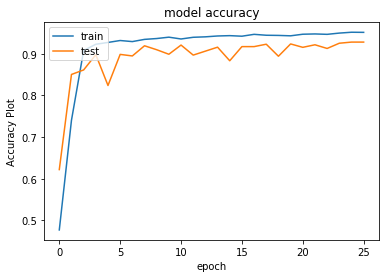

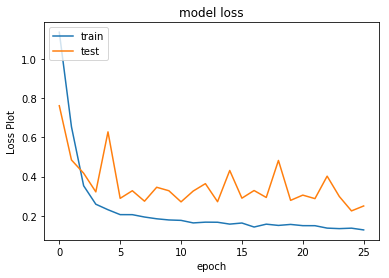

In [0]:
import matplotlib.pyplot as plt
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                 10      418  ...                   0                 1
STANDING                 0      101  ...                   0                 0
WALKING                  0        0  ...                  12                16
WALKING_DOWNSTAIRS       0        0  ...                 418                 2
WALKING_UPSTAIRS         0        0  ...                   8               463

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 2s 805us/step


[0.2503413134932189, 0.9280624363759755]

<h2> Divide And Conquer </h2>

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = 'HAR/UCI_HAR_Dataset/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
        signals_data.append(_read_csv(filename).values) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
def load_y_static_dynamic(subset):
  
  #static - 0
  #dynamic - 1
  
  filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
  y = _read_csv(filename)[0]
  
  y[y<=3] = 0
  y[y>3] = 1
  
  return pd.get_dummies(y).values

In [0]:
X_train_st_dy, X_val_st_dy = load_signals('train'), load_signals('test')
Y_train_st_dy, Y_val_st_dy = load_y_static_dynamic('train'), load_y_static_dynamic('test')

In [0]:
print(X_train_st_dy.shape)
print(X_val_st_dy.shape)
print(Y_train_st_dy.shape)
print(Y_val_st_dy.shape)

(7352, 128, 9)
(2947, 128, 9)
(7352, 2)
(2947, 2)


<h3> Determine whether Static or Dynamic Activity </h3>

In [0]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras import backend as K

K.clear_session()
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                99250     
_________________________________________________________________
dense_2 (Dense)              (None, 2)               

In [0]:
import math
adam = keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_st_dy,Y_train_st_dy, epochs=20, batch_size=16,validation_data=(X_val_st_dy, Y_val_st_dy), verbose=1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 4s 557us/step - loss: 0.0407 - acc: 0.9838 - val_loss: 0.0407 - val_acc: 0.9820
Epoch 2/20
7352/7352 [==============================] - 4s 500us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0662 - val_acc: 0.9810
Epoch 3/20
7352/7352 [==============================] - 4s 489us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0864 - val_acc: 0.9803
Epoch 4/20
7352/7352 [==============================] - 4s 478us/step - loss: 9.9117e-04 - acc: 0.9997 - val_loss: 0.0278 - val_acc: 0.9885
Epoch 5/20
7352/7352 [==============================] - 4s 481us/step - loss: 6.8691e-05 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9905
Epoch 6/20
7352/7352 [==============================] - 3s 473us/step - loss: 1.1270e-05 - acc: 1.0000 - val_loss: 0.0190 - val_acc: 0.9912
Epoch 7/20
7352/7352 [==============================] - 4s 481us/step - loss: 8.2356e-06 - acc: 1.0000 - val_loss: 0.0254 - 

In [0]:
_,acc_val = model.evaluate(X_val_st_dy,Y_val_st_dy,verbose=0)
_,acc_train = model.evaluate(X_train_st_dy,Y_train_st_dy,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 1.0 test_accuracy 0.997964031218188


In [0]:
model.save('final_model_st_dy.h5')

<h4> Classify Static Activity </h4>

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = 'HAR/UCI_HAR_Dataset/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
        signals_data.append(_read_csv(filename).values) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
def load_y_static(subset):
  
  #static - 0
  #dynamic - 1
  
  filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
  y = _read_csv(filename)[0]
  
  y_true = y>3
  y = y[y>3]
  
  return pd.get_dummies(y).values, y_true

In [0]:
X_train_st, X_val_st = load_signals('train'), load_signals('test')

Y_train_st, y_true_train = load_y_static('train')
Y_val_st, y_true_test    = load_y_static('test')
X_train_static_sorted = X_train_st[y_true_train]
X_val_static_sorted = X_val_st[y_true_test]

In [0]:
print(X_train_static_sorted.shape)
print(X_val_static_sorted.shape)
print(Y_train_st.shape)
print(Y_val_st.shape)

(4067, 128, 9)
(1560, 128, 9)
(4067, 3)
(1560, 3)


<h4> Apply CNN </h4>

In [0]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

K.clear_session()
#np.random.seed(10)
#tf.set_random_seed(10)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model1 = Sequential()
model1.add(Conv1D(filters=30, kernel_size=3, activation='relu', kernel_initializer='he_uniform',input_shape=(128,9)))
model1.add(Conv1D(filters=50, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model1.add(Conv1D(filters=100, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model1.add(Flatten())
model1.add(Dense(50, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(3, activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 30)           840       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 50)           4550      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 122, 100)          15100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                610050    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [0]:
import math
adam = keras.optimizers.Adam(lr=0.001)

model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model1.fit(X_train_static_sorted,Y_train_st, epochs=30, batch_size=32, validation_data=(X_val_static_sorted, Y_val_st), verbose=1)

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 2s 537us/step - loss: 0.0749 - acc: 0.9919 - val_loss: 0.8928 - val_acc: 0.9179
Epoch 2/30
4067/4067 [==============================] - 1s 346us/step - loss: 0.0734 - acc: 0.9916 - val_loss: 0.9029 - val_acc: 0.9179
Epoch 3/30
4067/4067 [==============================] - 1s 357us/step - loss: 0.1102 - acc: 0.9916 - val_loss: 0.8983 - val_acc: 0.9154
Epoch 4/30
4067/4067 [==============================] - 1s 338us/step - loss: 0.1190 - acc: 0.9887 - val_loss: 1.0461 - val_acc: 0.9051
Epoch 5/30
4067/4067 [==============================] - 1s 332us/step - loss: 0.0465 - acc: 0.9904 - val_loss: 0.9201 - val_acc: 0.9167
Epoch 6/30
4067/4067 [==============================] - 1s 356us/step - loss: 0.0224 - acc: 0.9985 - val_loss: 0.9158 - val_acc: 0.9186
Epoch 7/30
4067/4067 [==============================] - 1s 345us/step - loss: 0.0138 - acc: 0.9983 - val_loss: 0.9562 - val_acc: 0.9122


In [0]:
_,acc_val = model1.evaluate(X_val_static_sorted,Y_val_st,verbose=0)
_,acc_train = model1.evaluate(X_train_static_sorted,Y_train_st,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 0.9960658962380132 test_accuracy 0.916025641025641


In [0]:
import math
adam = keras.optimizers.Adam(lr=0.001)

model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model1.fit(X_train_static_sorted,Y_train_st, epochs=100, batch_size=32, validation_data=(X_val_static_sorted, Y_val_st), verbose=1)

Train on 4067 samples, validate on 1560 samples
Epoch 1/100
4067/4067 [==============================] - 2s 561us/step - loss: 0.1497 - acc: 0.9375 - val_loss: 0.9678 - val_acc: 0.8885
Epoch 2/100
4067/4067 [==============================] - 1s 338us/step - loss: 0.1500 - acc: 0.9287 - val_loss: 0.8222 - val_acc: 0.8955
Epoch 3/100
4067/4067 [==============================] - 1s 331us/step - loss: 0.1341 - acc: 0.9380 - val_loss: 0.9569 - val_acc: 0.8949
Epoch 4/100
4067/4067 [==============================] - 1s 337us/step - loss: 0.1302 - acc: 0.9395 - val_loss: 0.7188 - val_acc: 0.8609
Epoch 5/100
4067/4067 [==============================] - 1s 332us/step - loss: 0.1440 - acc: 0.9366 - val_loss: 0.7026 - val_acc: 0.8981
Epoch 6/100
4067/4067 [==============================] - 1s 337us/step - loss: 0.1106 - acc: 0.9481 - val_loss: 0.6365 - val_acc: 0.9147
Epoch 7/100
4067/4067 [==============================] - 1s 349us/step - loss: 0.1261 - acc: 0.9434 - val_loss: 0.7572 - val_acc: 

In [0]:
_,acc_val = model1.evaluate(X_val_static_sorted,Y_val_st,verbose=0)
_,acc_train = model1.evaluate(X_train_static_sorted,Y_train_st,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 0.9997541185148758 test_accuracy 0.9179487179487179


In [0]:
model1.save('final_model_static.h5')

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
from sklearn import metrics
import matplotlib.pyplot as plt
ACTIVITIES = {
    0: 'SITTING',
    1: 'STANDING',
    2: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix_cnn(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)


In [0]:
print(confusion_matrix_cnn(Y_val_st, model.predict(X_val_static_sorted)))

[[537   0   0]
 [  0 427  64]
 [  0  41 491]]


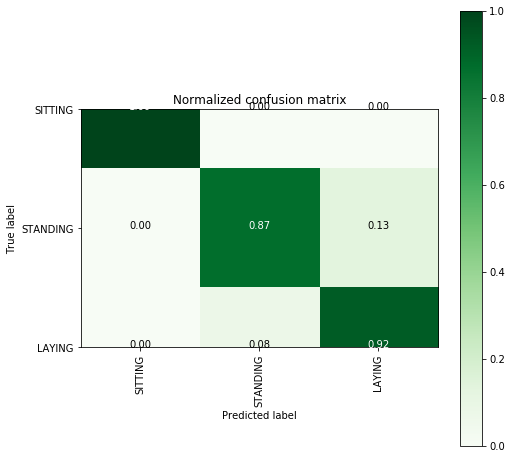

In [0]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(Y_val_st, model.predict(X_val_static_sorted))
plot_confusion_matrix(cm, classes=['SITTING','STANDING','LAYING'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

<h3> Hyper-Parameter tuning with Keras SKlearn Wrapper </h3>

In [0]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.regularizers import l2
import random

<h5> Batch Size & Epoch Tuning</h5>

In [0]:
def cnn_wraper_model(batch, epoch):
  
  np.random.seed(0)
  tf.set_random_seed(0)
  sess = tf.Session(graph=tf.get_default_graph())
  K.set_session(sess)

  # Initiliazing the sequential model
  model = Sequential()
  
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(128,9)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
  
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=3))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train_static_sorted,Y_train_st, epochs=epoch, batch_size=batch, validation_data=(X_val_static_sorted, Y_val_st), verbose=1)

  return model

In [0]:
# create model
model = KerasClassifier(build_fn=cnn_wraper_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]

param_grid = {'batch': batch_size, 'epoch': epochs}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train_static_sorted, Y_train_st)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 3s 845us/step - loss: 0.2373 - acc: 0.9012 - val_loss: 0.3260 - val_acc: 0.8821
Epoch 2/10
4067/4067 [==============================] - 3s 697us/step - loss: 0.1866 - acc: 0.9181 - val_loss: 0.3095 - val_acc: 0.8987
Epoch 3/10
4067/4067 [==============================] - 3s 733us/step - loss: 0.1679 - acc: 0.9240 - val_loss: 0.3257 - val_acc: 0.8519
Epoch 4/10
4067/4067 [==============================] - 3s 777us/step - loss: 0.1769 - acc: 0.9253 - val_loss: 0.3715 - val_acc: 0.8731
Epoch 5/10
4067/4067 [==============================] - 3s 765us/step - loss: 0.1425 - acc: 0.9326 - val_loss: 0.3981 - val_acc: 0.8904
Epoch 6/10
4067/4067 [==============================] - 3s 816us/step - loss: 0.1304 - acc: 0.9393 - val_loss: 0.3815 - val_acc: 0.8865
Epoch 7/10
4067/4067 [==============================] - 3s 783us/step - loss: 0.1185 - acc: 0.9432 - val_loss: 0.4124 - val_acc: 0.8872

<h5> Optimizer </h5>

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [0]:
best_epoch = 100
best_batch = 40

In [0]:
def cnn_wraper_model(optimizer):
  
  np.random.seed(0)
  tf.set_random_seed(0)
  sess = tf.Session(graph=tf.get_default_graph())
  K.set_session(sess)

  # Initiliazing the sequential model
  model = Sequential()
  
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(128,9)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
  
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=3))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  model.fit(X_train_static_sorted,Y_train_st, epochs=best_epoch, batch_size=best_batch, validation_data=(X_val_static_sorted, Y_val_st), verbose=1)
  
  print("*"*50)

  return model

In [0]:
# create model
model = KerasClassifier(build_fn=cnn_wraper_model, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax']

param_grid = {'optimizer': optimizer}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train_static_sorted, Y_train_st)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Train on 4067 samples, validate on 1560 samples
Epoch 1/100
4067/4067 [==============================] - 10s 2ms/step - loss: 0.3414 - acc: 0.8515 - val_loss: 0.3408 - val_acc: 0.8782
Epoch 2/100
4067/4067 [==============================] - 1s 237us/step - loss: 0.2306 - acc: 0.8989 - val_loss: 0.3190 - val_acc: 0.8795
Epoch 3/100
4067/4067 [==============================] - 1s 243us/step - loss: 0.2229 - acc: 0.9031 - val_loss: 0.3427 - val_acc: 0.8423
Epoch 4/100
4067/4067 [==============================] - 1s 253us/step - loss: 0.2138 - acc: 0.9080 - val_loss: 0.3075 - val_acc: 0.8776
Epoch 5/100
4067/4067 [==============================] - 1s 245us/step - loss: 0.2088 - acc: 0.9100 - val_loss: 0.3096 - val_acc: 0.8654
Epoch 6/100
4067/4067 [==============================] - 1s 246us/step - loss: 0.2030 - acc: 0.9120 - val_loss: 0.3000 - val_acc: 0.8763
Epoch 7/100
4067/4067 [==============================] - 1s 239us/step - loss: 0.1980 - acc: 0.9159 - val_loss: 0.3055 - val_acc: 0

<h4> Neurons </h4>

In [0]:
def cnn_wraper_model(neuron_1, neuron_2, neuron_3):
  
  np.random.seed(0)
  tf.set_random_seed(0)
  sess = tf.Session(graph=tf.get_default_graph())
  K.set_session(sess)

  # Initiliazing the sequential model
  model = Sequential()
  
  model.add(Conv1D(filters=neuron_1, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform', input_shape=(128,9)))
  model.add(Conv1D(filters=neuron_2, kernel_size=3, activation='relu', kernel_regularizer=l2(0.82), kernel_initializer='he_uniform'))
  
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(neuron_3, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  
  adam = keras.optimizers.Adam(lr=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  model.fit(X_train_static_sorted,Y_train_st, epochs=60, batch_size=64, validation_data=(X_val_static_sorted, Y_val_st))

  return model

In [0]:
# create model
model = KerasClassifier(build_fn=cnn_wraper_model, verbose=0)

# define the grid search parameters
neuron_1 = [28,72,124]
neuron_2 = [32,64,128]
neuron_3 = [16,32,64]

param_grid = {'neuron_1': neuron_1, 'neuron_2': neuron_2, 'neuron_3': neuron_3}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train_static_sorted, Y_train_st)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Train on 4067 samples, validate on 1560 samples
Epoch 1/60
4067/4067 [==============================] - 2s 437us/step - loss: 38.3405 - acc: 0.8591 - val_loss: 25.3567 - val_acc: 0.8596
Epoch 2/60
4067/4067 [==============================] - 1s 143us/step - loss: 17.5454 - acc: 0.9078 - val_loss: 11.3717 - val_acc: 0.8494
Epoch 3/60
4067/4067 [==============================] - 1s 140us/step - loss: 7.6627 - acc: 0.9105 - val_loss: 4.8921 - val_acc: 0.8545
Epoch 4/60
4067/4067 [==============================] - 1s 146us/step - loss: 3.2161 - acc: 0.9078 - val_loss: 2.1065 - val_acc: 0.8577
Epoch 5/60
4067/4067 [==============================] - 1s 142us/step - loss: 1.3636 - acc: 0.9083 - val_loss: 0.9805 - val_acc: 0.8506
Epoch 6/60
4067/4067 [==============================] - 1s 142us/step - loss: 0.6303 - acc: 0.9139 - val_loss: 0.6135 - val_acc: 0.8545
Epoch 7/60
4067/4067 [==============================] - 1s 150us/step - loss: 0.4032 - acc: 0.9012 - val_loss: 0.4467 - val_acc: 0.8

<h4> Classify Dynamic Activity </h4>

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = 'HAR/UCI_HAR_Dataset/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
        signals_data.append(_read_csv(filename).values) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
def load_y_dynamic(subset):
  
  #static - 0
  #dynamic - 1
  
  filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
  y = _read_csv(filename)[0]
  
  y_true = y<=3
  y = y[y<=3]
  
  return pd.get_dummies(y).values, y_true

In [0]:
X_train_dy, X_val_dy = load_signals('train'), load_signals('test')

Y_train_dy, y_true_train = load_y_dynamic('train')
Y_val_dy, y_true_test    = load_y_dynamic('test')
X_train_dynamic_sorted = X_train_dy[y_true_train]
X_val_dynamic_sorted = X_val_dy[y_true_test]

In [0]:
print(X_train_dynamic_sorted.shape)
print(X_val_dynamic_sorted.shape)
print(Y_train_dy.shape)
print(Y_val_dy.shape)

(3285, 128, 9)
(1387, 128, 9)
(3285, 3)
(1387, 3)


In [0]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

K.clear_session()
np.random.seed(10)
tf.set_random_seed(10)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=30, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=50, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Conv1D(filters=100, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 30)           840       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 50)           4550      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 122, 100)          15100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                610050    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_

In [0]:
import math
adam = keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_dynamic_sorted,Y_train_dy, epochs=60, batch_size=32, validation_data=(X_val_dynamic_sorted, Y_val_dy), verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3285 samples, validate on 1387 samples
Epoch 1/60




3285/3285 [==============================] - 8s 2ms/step - loss: 0.8995 - acc: 0.5416 - val_loss: 0.6522 - val_acc: 0.7246
Epoch 2/60
3285/3285 [==============================] - 1s 327us/step - loss: 0.4155 - acc: 0.8128 - val_loss: 0.4804 - val_acc: 0.9048
Epoch 3/60
3285/3285 [==============================] - 1s 328us/step - loss: 0.1727 - acc: 0.9196 - val_loss: 0.4215 - val_acc: 0.9142
Epoch 4/60
3285/3285 [==============================] - 1s 340us/step - loss: 0.1093 - acc: 0.9522 - val_loss: 0.2881 - val_acc: 0.9567
Epoch 5/60
3285/3285 [==============================] - 1s 341us/step - loss: 0.0984 - acc: 0.9540 - val_loss: 0.2143 - val_acc: 0.9676
Epoch 6/60
3285/3285 [==============================] - 1s 357us/step - loss: 0.0828 - acc: 0.9598 - val_loss: 0.2410 - val_acc: 0.9632
Epoch 7/60
3285/3285 [==============

In [0]:
_,acc_val = model.evaluate(X_val_dynamic_sorted,Y_val_dy,verbose=0)
_,acc_train = model.evaluate(X_train_dynamic_sorted,Y_train_dy,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 1.0 test_accuracy 0.9754866618601298


In [0]:
model.save('final_model_dynamic.h5')

<h5> Final Prediction PipeLine </h5>

In [0]:
def load_y_final(subset):
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return y

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = 'HAR/UCI_HAR_Dataset/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
        signals_data.append(_read_csv(filename).values) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
X_train_st_dy, X_val_st_dy = load_signals('train'), load_signals('test')

In [0]:
print(X_train_st_dy.shape)
print(X_val_st_dy.shape)

(7352, 128, 9)
(2947, 128, 9)


In [0]:
##loading keras models and picle files for scaling data 
from keras.models import load_model
import pickle
model_st_dy = load_model('final_model_st_dy.h5')
model_dynamic = load_model('final_model_dynamic.h5')
model_static = load_model('final_model_static.h5')

In [0]:
def predict_activity(X):
  predict_st_dy = model_st_dy.predict(X)
  y_pred_st_dy =  np.argmax(predict_st_dy, axis=1)
  
  #static data
  X_static = X[y_pred_st_dy==1]
  #dynamic data
  X_dynamic = X[y_pred_st_dy==0]
  
  predict_st = model_static.predict(X_static)
  predict_static = np.argmax(predict_st,axis=1)
  predict_static_class_label = predict_static + 4
  
  predict_dy = model_dynamic.predict(X_dynamic)
  predict_dynamic = np.argmax(predict_dy,axis=1)
  predict_dynamic_class_label = predict_dynamic + 1

  i,j = 0,0 
  final_pred = []
  for pred in y_pred_st_dy:
    if pred == 1:
      final_pred.append(predict_static_class_label[i])
      i = i + 1
    else:
      final_pred.append(predict_dynamic_class_label[j])
      j = j + 1 
      
  return final_pred

In [0]:
#predicting 
final_pred_val = predict_activity(X_val_st_dy)
final_pred_train = predict_activity(X_train_st_dy)

In [0]:
##accuracy of train and test
from sklearn.metrics import accuracy_score
print('Accuracy of train data',accuracy_score(load_y_final('train'),final_pred_train))
print('Accuracy of validation data',accuracy_score(load_y_final('test'),final_pred_val))

Accuracy of train data 0.9998639825897715
Accuracy of validation data 0.9440108585001696


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(load_y_final('test'), final_pred_val)
cm

array([[490,   0,   6,   0,   0,   0],
       [  1, 446,  24,   0,   0,   0],
       [  3,   0, 417,   0,   0,   0],
       [  0,   2,   0, 397,  68,  24],
       [  1,   3,   0,  33, 495,   0],
       [  0,   0,   0,   0,   0, 537]])

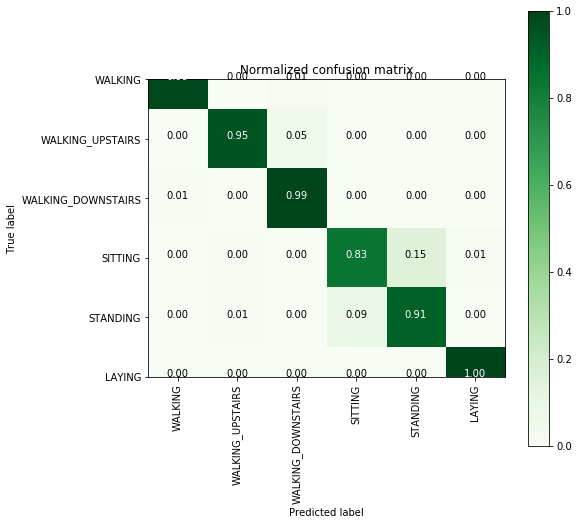

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
labels=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
plot_confusion_matrix(cm, classes=labels, 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

<h2> Observations </h2>

<h4> Single Layer </h4>

In [0]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Serial No","Drop Out", "Hidden Layer" ,"Loss", "Validation Accuracy"]
table.add_row(["1", '0.5', '32', '0.665', '0.87'])
table.add_row(["2", '0.5', '128', '0.365', '0.925'])
table.add_row(["3", '0.6', '324', '0.24', '0.922'])
print(table)

+-----------+----------+--------------+-------+---------------------+
| Serial No | Drop Out | Hidden Layer |  Loss | Validation Accuracy |
+-----------+----------+--------------+-------+---------------------+
|     1     |   0.5    |      32      | 0.665 |         0.87        |
|     2     |   0.5    |     128      | 0.365 |        0.925        |
|     3     |   0.6    |     324      |  0.24 |        0.922        |
+-----------+----------+--------------+-------+---------------------+


<h4> 2 - Layer </h4>

In [0]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Serial No", "Hidden Layer 1", "Hidden Layer 2", "Drop Out 1", "Drop Out 2", "Loss", "Validation Accuracy"]
table.add_row(["1", '256', '128', '0.7', '0.6', '0.608', '0.89'])
table.add_row(["2", '128', '64', '0.2', '0.5', '0.244', '0.927'])
print(table)

+-----------+----------------+----------------+------------+------------+-------+---------------------+
| Serial No | Hidden Layer 1 | Hidden Layer 2 | Drop Out 1 | Drop Out 2 |  Loss | Validation Accuracy |
+-----------+----------------+----------------+------------+------------+-------+---------------------+
|     1     |      256       |      128       |    0.7     |    0.6     | 0.608 |         0.89        |
|     2     |      128       |       64       |    0.2     |    0.5     | 0.244 |        0.927        |
+-----------+----------------+----------------+------------+------------+-------+---------------------+


<h4> Divide & Conquer </h4>

In [3]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Activity", "Hidden Layer 1", "Hidden Layer 2", "Hidden Layer 3", "Drop Out", "Validation Accuracy"]
table.add_row(["Static", '30', '50', '100', '0.5', '0.916'])
table.add_row(["Dynamic",'30', '50', '100', '0.5', '0.975'])
print(table)

+----------+----------------+----------------+----------------+----------+---------------------+
| Activity | Hidden Layer 1 | Hidden Layer 2 | Hidden Layer 3 | Drop Out | Validation Accuracy |
+----------+----------------+----------------+----------------+----------+---------------------+
|  Static  |       30       |       50       |      100       |   0.5    |        0.916        |
| Dynamic  |       30       |       50       |      100       |   0.5    |        0.975        |
+----------+----------------+----------------+----------------+----------+---------------------+


<h3> Observation </h3>

The Final Accuracy for the divide & Conquer approach is found to be <b>94.6%</b>

<h3> Conclusion </h3>

1. 2-Layer Network with a small number of hidden unit at initial layers is useful
2. I got an accuracy of 94.0% for the divide & conquer approach.
3. Drop out rate is more effective in the range of 5-7
4. Seems to be lot of confusion in between the static activity or dynamic activities among them.